In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator, Aer
from qiskit.providers.fake_provider import FakeManila, FakeToronto, FakeJakartaV2
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter
import qiskit.quantum_info as qi
import qiskit
from qiskit.visualization import plot_histogram

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import scipy
import os
import sys
import itertools
from numpy.random import Generator, PCG64
from datetime import date
import pathlib
import inspect
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
plot_path = f'{module_path}/plots'
sys.path.append(module_path)

from src.feedforward import QExtremeLearningMachine
from src.rewinding import QRewindingRC, QRewindingStatevectorRC
from src.data import DataSource

In [2]:
from IPython.display import display

qiskit.__qiskit_version__

{'qiskit-terra': '0.24.0', 'qiskit-aer': '0.12.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

# How to use Qiskit Statevector / DensityMatrix to speed up simulations with partial measurements

# Partial measurement / reset

In [77]:
nqubits = 3
nmeas = 1
qmeas = [*range(nmeas)]


# QC
qc = QuantumCircuit(nqubits)
qc.h(0)
qc.h(2)
qc.cx(0,1)
qc.cx(1,2)



# partial measurement / reset
rho = qi.DensityMatrix(qc)


# optional: get samples
counts = rho.sample_counts(shots=2**10)
# counts = rho.probabilities()

# reset: trace out qubit
rho_meas = qi.partial_trace(state=rho, qargs=qmeas)

# reconstruct rho all qubits
rho_reset = qi.DensityMatrix(qi.Statevector.from_label('0'*(nmeas)).data)

rho_full = qi.DensityMatrix(np.kron(rho_reset.data, rho_meas))

# set circuit to reset state
# qc.set_density_matrix(dm)


# continue circuit


# sample full measurement

In [78]:
# getting dm from circuit

statev_init = qi.Statevector.from_label('0'*nqubits)
rho = qi.DensityMatrix(statev_init.data)
rho = rho.evolve(qc)

rho2 = qi.DensityMatrix(qc)

print('DM from circuit is the same as evolved:', np.allclose(rho2.data, rho.data))

True


In [85]:
# resetting by hand
rho_meas = qi.partial_trace(state=rho, qargs=qmeas)
rho_reset = qi.DensityMatrix(qi.Statevector.from_label('0'*(nmeas)).data)

# reverse qiskit ordering
rho_full = rho_meas.tensor(rho_reset)
rho_full2 = qi.DensityMatrix(np.kron(rho_meas.data, rho_reset.data))

print('Qiskit tensor is a kronecker product:', np.allclose(rho_full.data, rho_full2.data))

Qiskit tensor is a kronecker product: True


In [87]:
# resetting
rho_meas = qi.partial_trace(state=rho, qargs=qmeas)
rho_reset = qi.DensityMatrix(qi.Statevector.from_label('0'*nmeas).data)
rho_full = rho_meas.tensor(rho_reset)

rho_full_auto = rho.reset(qargs=qmeas)

print('Qiskit reset is a partial trace & tensor product with |0> state:', np.allclose(rho_full.data, rho_full_auto.data))

Qiskit reset is a partial trace & tensor product with |0> state: True


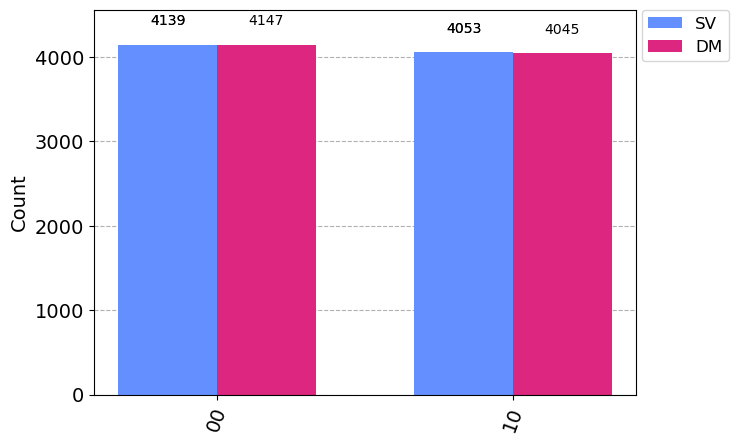

In [102]:
# DM reset vs SV reset

shots = 2**13

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
# qc.h(1)

sv = qi.Statevector.from_label('0'*2)
dm = qi.DensityMatrix(sv.data)

sv = sv.evolve(qc)
dm = dm.evolve(qc)

dm = dm.reset([0])

# sv = sv.reset([0])
sv = qi.partial_trace(sv, qargs=[0])
sv0 = qi.Statevector.from_label('0')
sv = sv.tensor(sv0)
# sv = sv0.tensor(sv)

plot_histogram([sv.sample_counts(shots=shots), dm.sample_counts(shots=shots)], legend=['SV', 'DM'])

# Time rho

In [114]:
from circuits import ising_circuit

def time_partial_measurements(nqubits = 5, nmeas = 3, max_partial_measurements = 5):
    
    
    qmeas = [*range(nmeas)] # measure first few qubits
    shots = 2**13
    qc = ising_circuit(nqubits=nqubits)

    npmeas = []
    dm_times = []
    aer_times = []
    sv_times = []

    for n_partial_measurements in range(max_partial_measurements+1):
        print(f'{n_partial_measurements} mid circuit measurements:')
        npmeas.append(n_partial_measurements)


        t0 = time.time()
        #
        statev = qi.Statevector.from_label('0'*nqubits)
        statev = statev.evolve(qc)
        for _ in range(n_partial_measurements):
            # counts = statev.sample_counts(shots=shots)
            # statev = statev.reset(qargs=qmeas)
            statev_meas = qi.partial_trace(statev, qargs=qmeas)
            statev_reset = qi.Statevector.from_label('0'*nmeas)
            statev = statev_meas.tensor(statev_reset)
            statev = statev.evolve(qc)
        counts_sv = statev.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        sv_times.append(t1)
        print(f' Statevector: {t1:.2f}s')
        

        t0 = time.time()
        #
        statev_init = qi.Statevector.from_label('0'*nqubits)
        rho = qi.DensityMatrix(statev_init.data)
        rho = rho.evolve(qc)
        for _ in range(n_partial_measurements):
            # counts = rho.sample_counts(shots=shots, qargs=qmeas)
            # rho = rho.reset(qargs=qmeas)
            rho_meas = qi.partial_trace(state=rho, qargs=qmeas)
            rho_reset = qi.DensityMatrix(qi.Statevector.from_label('0'*nmeas).data)
            rho = rho_meas.tensor(rho_reset)
            rho = rho.evolve(qc)
        counts_rho = rho.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        dm_times.append(t1)
        print(f' Density Matrix {t1:.2f}s')


        t0 = time.time()
        #
        sim = AerSimulator()
        qc_meas = QuantumCircuit(nqubits, nqubits)
        qc_meas.append(qc, qargs=[*range(nqubits)])
        for _ in range(n_partial_measurements):
            # qc_meas.measure(qmeas, qmeas)
            qc_meas.reset(qmeas)
            qc_meas.append(qc, qargs=[*range(nqubits)])
        qc_meas.measure([*range(nqubits)], [*range(nqubits)])
        compiled_qc = transpile(qc_meas, sim)
        job = sim.run(compiled_qc, shots=shots)
        result = job.result()
        counts_aer = result.get_counts()
        #
        t1 = time.time() - t0
        aer_times.append(t1)
        print(f' AerSimulator: {t1:.2f}s')

    plt.figure()
    plt.plot(npmeas, dm_times, label='Density Matrix')
    plt.plot(npmeas, aer_times, label='AerSimulator')
    plt.plot(npmeas, sv_times, label='Statevector')
    plt.title('Timings of Methods for Partial Measurements')
    plt.ylabel('Seconds')
    plt.xlabel('Number Resets / Partial Measurements')
    plt.xticks(npmeas)
    plt.legend()
    plt.show()

    return counts_rho, counts_aer, counts_sv


0 mid circuit measurements:
 Statevector: 0.02s
 Density Matrix 1.54s
 AerSimulator: 0.02s
1 mid circuit measurements:
 Statevector: 1.42s
 Density Matrix 2.81s
 AerSimulator: 0.99s
2 mid circuit measurements:
 Statevector: 2.82s
 Density Matrix 4.20s
 AerSimulator: 8.74s
3 mid circuit measurements:
 Statevector: 4.22s
 Density Matrix 5.61s
 AerSimulator: 11.45s
4 mid circuit measurements:
 Statevector: 5.57s
 Density Matrix 6.95s
 AerSimulator: 14.18s
5 mid circuit measurements:
 Statevector: 6.96s
 Density Matrix 8.37s
 AerSimulator: 16.88s


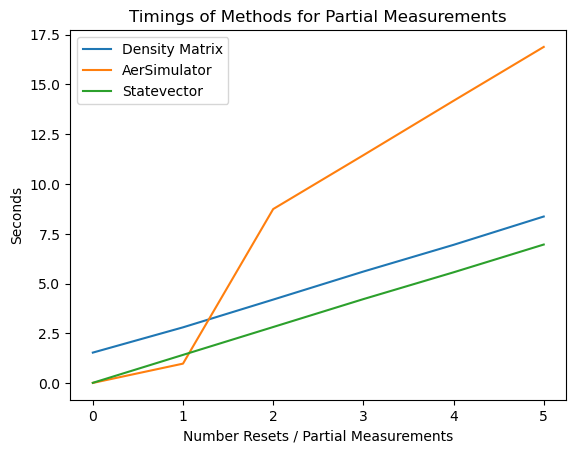

In [115]:
counts_rho, counts_aer, counts_sv = time_partial_measurements(10, 5, 5)
# counts_rho, counts_aer, counts_sv = time_partial_measurements(3, 2, 5)

# print(counts_aer)

# plot_histogram([counts_rho, counts_aer, counts_sv], legend=['DM', 'Aer', 'SV'], color=['crimson','midnightblue', 'green'])

# 

In [10]:
# # Noisy statevector
# # dm after measurement

# # provider = IBMProvider()
# # backend = provider.get_backend('ibmq_manila')
# # noise_model = NoiseModel.from_backend(backend)

# noise_model = NoiseModel.from_backend(FakeJakartaV2())

# noisy_simulator = AerSimulator(method = 'statevector', noise_model = noise_model)


# circ = QuantumCircuit(5, 2)
# circ.h(2)
# circ.cx(2, 1)
# circ.cx(1, 0)
# circ.cx(2, 3)
# circ.cx(3, 4)
# circ.barrier()
# circ.measure(0, 0)
# circ.measure(1, 1)
# circ.save_density_matrix(qubits=[2, 3, 4], label="rho", conditional=True)
# circ.draw('mpl')


# job = noisy_simulator.run(circ)
# result = job.result()

# # Get statevector for each measurement:
# for meas, state in result.data()['rho'].items():
#     display(meas)
#     display(state.draw('latex'))

In [11]:
# # Snapshot

# simulator = Aer.get_backend('aer_simulator_statevector')
# nqubits = 2
# nmeas = 2
# shots = 2**13

# circuit = QuantumCircuit(nqubits, nmeas)

# circuit.h(0)
# circuit.cx(0, 1)

# circuit.measure([*range(nqubits)], [*range(nmeas)])

# # circuit = transpile(circuit, simulator)

# print(type(circuit))
# # qiskit.circuit.QuantumCircuit.snapshot
# circuit.snapshot(label = "psi", snapshot_type = "statevector")
                 
# results = simulator.run(circuit, shots = shots, memory = True).result()
# states = results.data()["snapshots"]["statevector"]["psi"]

In [12]:
# average statevector after measurement

sim = Aer.get_backend('aer_simulator_statevector')
nqubits = 2
nmeas = 2
shots = 2**13

statev_init = qi.Statevector.from_label('0'*nqubits)

qc = QuantumCircuit(nqubits, nmeas)
qc.set_statevector(statev_init) 

# do circuit
qc.h(0)
qc.cx(0, 1)

qc.save_statevector()

qc.measure([*range(nqubits)], [*range(nmeas)])
qc = transpile(qc, sim)
result = sim.run(qc, shots=shots).result()

statev_post = result.get_statevector(qc)

print('sv before measurement', statev_post)
print(result.get_counts())

sv before measurement Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))
{'11': 4159, '00': 4033}


In [13]:
# average statevector after measurement

sim = Aer.get_backend('aer_simulator_statevector')
nqubits = 2
nmeas = 2
shots = 2**10

for _ in range(5):

    qc = QuantumCircuit(nqubits, nmeas)

    # do circuit
    qc.h(0)
    qc.cx(0, 1)

    qc.measure([*range(nqubits)], [*range(nmeas)])
    qc = transpile(qc, sim)

    qc.save_statevector()
    result = sim.run(qc, shots=shots).result()

    statev_post = result.get_statevector(qc)

    print('sv after measurement', statev_post.data)
print(result.get_counts())


list_sv = [] # list of row vectors
for _ in range(shots):

    qc = QuantumCircuit(nqubits, nmeas)

    # do circuit
    qc.h(0)
    qc.cx(0, 1)

    qc.measure([*range(nqubits)], [*range(nmeas)])
    qc = transpile(qc, sim)

    qc.save_statevector()
    result = sim.run(qc, shots=1).result()

    statev_post = result.get_statevector(qc)

    list_sv.append(statev_post.data)

sv_arr = np.vstack(list_sv)
avg_sv = sv_arr.mean(axis=0)
print('-' * 10)
print(avg_sv)



qc = QuantumCircuit(nqubits, nmeas)

# do circuit
qc.h(0)
qc.cx(0, 1)

qc.save_statevector()
qc.measure([*range(nqubits)], [*range(nmeas)])
qc = transpile(qc, sim)

result = sim.run(qc, shots=1).result()

statev_post = result.get_statevector(qc)

# res = statev_post.data**2
res = np.abs(statev_post.data)
res = res / np.linalg.norm(res, ord=1)

print('-' * 10)
print('average estimated from SV before measurement')
print(res)

sv after measurement [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
sv after measurement [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
sv after measurement [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
sv after measurement [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
sv after measurement [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
{'00': 533, '11': 491}
----------
[0.50097656+0.j 0.        +0.j 0.        +0.j 0.49902344+0.j]
----------
average estimated from SV before measurement
[0.5 0.  0.  0.5]


In [14]:
# simulator == density matrix

nqubits = 2
nmeas = 2
shots = 2**13

sim = Aer.get_backend('aer_simulator_statevector')
qc = QuantumCircuit(nqubits, nmeas)
qc.h(0)
qc.cx(0, 1)
qc.rz(np.pi/16, 1)
qc.ry(np.pi/16, 1)

qc.save_statevector()
qc = transpile(qc, sim)
result = sim.run(qc, shots=shots).result()
statev = result.get_statevector(qc)


# dm
sim = Aer.get_backend('aer_simulator_density_matrix')
qc = QuantumCircuit(nqubits, nmeas)
qc.h(0)
qc.cx(0, 1)
qc.rz(np.pi/16, 1)
qc.ry(np.pi/16, 1)

dm = qi.DensityMatrix.from_instruction(qc)


# dm from SV
dm_sv = qi.DensityMatrix(statev.data)


print('sv', statev, statev.probabilities(), sep='\n')
print('dm from s', dm_sv, dm_sv.probabilities(), sep='\n')
print('dm', dm, dm.probabilities(), sep='\n')
print('dm is pure:', np.allclose(np.matmul(dm.data, dm.data), dm.data))
print('Same:', np.allclose(dm.data, dm_sv.data))

sv
Statevector([ 0.70031335-0.06897484j, -0.06897484-0.00679343j,
              0.06897484-0.00679343j,  0.70031335+0.06897484j],
            dims=(2, 2))
[0.49519632 0.00480368 0.00480368 0.49519632]
dm from s
DensityMatrix([[ 0.49519632-9.53869559e-19j, -0.04783543+9.51505844e-03j,
                 0.04877258-2.05518772e-19j,  0.48568126-9.66080095e-02j],
               [-0.04783543-9.51505844e-03j,  0.00480368+2.24549168e-20j,
                -0.00471138-9.37151458e-04j, -0.04877258-1.05100505e-18j],
               [ 0.04877258-6.63372388e-20j, -0.00471138+9.37151458e-04j,
                 0.00480368-7.99638953e-21j,  0.04783543-9.51505844e-03j],
               [ 0.48568126+9.66080095e-02j, -0.04877258+5.23199498e-19j,
                 0.04783543+9.51505844e-03j,  0.49519632+1.58574911e-18j]],
              dims=(2, 2))
[0.49519632 0.00480368 0.00480368 0.49519632]
dm
DensityMatrix([[ 0.49519632+3.85610170e-18j, -0.04783543+9.51505844e-03j,
                 0.04877258+3.79792868e-19

In [15]:
# measure
# Measure subsystems and return outcome and post-measure state.
dm.measure()

('11',
 DensityMatrix([[0.+0.00000000e+00j, 0.+0.00000000e+00j,
                 0.+0.00000000e+00j, 0.+0.00000000e+00j],
                [0.+0.00000000e+00j, 0.+0.00000000e+00j,
                 0.+0.00000000e+00j, 0.+0.00000000e+00j],
                [0.+0.00000000e+00j, 0.+0.00000000e+00j,
                 0.+0.00000000e+00j, 0.+0.00000000e+00j],
                [0.+0.00000000e+00j, 0.+0.00000000e+00j,
                 0.+0.00000000e+00j, 1.-7.78701606e-18j]],
               dims=(2, 2)))

### SV usage

{'11': 4149, '00': 4043}
{'00': 4112, '11': 4080}


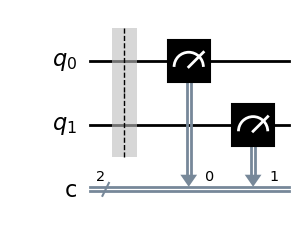

In [16]:
sim = Aer.get_backend('aer_simulator_statevector')
nqubits = 2
nmeas = 2
shots = 2**13

statev_init = qi.Statevector.from_label('0'*nqubits)

qc = QuantumCircuit(nqubits, nmeas)
qc.set_statevector(statev_init) 

# do circuit
qc.h(0)
qc.cx(0, 1)

qc.save_statevector()

qc.measure([*range(nqubits)], [*range(nmeas)])
qc = transpile(qc, sim)
result = sim.run(qc, shots=shots).result()

statev_post = result.get_statevector(qc)

print(result.get_counts())


qc = QuantumCircuit(nqubits, nmeas)
qc.set_statevector(statev_post) 

qc.measure([*range(nqubits)], [*range(nmeas)])
qc = transpile(qc, sim)
result = sim.run(qc, shots=shots).result()

print(result.get_counts())
qc.draw('mpl')